## Question 3

### Q3.1
Cleaning and preprocessing (SPAM). The majority of the decision tree is implemented in the decision tree starter file, and imported. I set the seed as 42, load the spam file and re-save a shuffled and split version of it. Then I reload the new version.

In [1491]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt

np.random.seed(42)
def load_and_save(filename, path, num = None, percent = None):
    """
    Shuffles, splits and adds the modified data to a new file,
    prepended with 'prep_'.
    """
    dataset = io.loadmat(path+filename)
    if percent:
        num = int(dataset["training_labels"].shape[0] * percent)
    t_dat, t_lbl, v_dat, v_lbl = split_data(dataset["training_data"], 
                                            dataset["training_labels"],
                                            num)
    dataset["training_data"] = t_dat
    dataset["training_labels"] = t_lbl
    dataset["valid_data"] = v_dat
    dataset["valid_labels"] = v_lbl
    
    io.savemat(path + "prep_" + filename, dataset)

def split_data(train, labels, num_valid):
    num_data = train.shape[0]
    assert num_valid <= len(train)
    assert num_data == labels.shape[0]
    idx = np.arange(num_data)
    np.random.shuffle(idx)
    train_shf = train[idx]
    lbl_shf = labels[idx]
    valid_dat = train_shf[:num_valid]
    valid_lbl = lbl_shf[:num_valid]
    train_dat = train_shf[num_valid:]
    train_lbl = lbl_shf[num_valid:]
    return train_dat, train_lbl, valid_dat, valid_lbl

def contrast_norm(td):
    return np.array([td[i] / np.linalg.norm(td[i]) for i in range(len(td))])

In [407]:
load_and_save("spam_data.mat", "datasets/spam_data/", percent = 0.2)

Cleaning and preprocessing (Titanic). The majority of the decision tree is implemented in the decision tree starter file, and imported. I set the seed as 42, load the .csv file. The function below then creates a new .mat file in the same folder, and draws the dataset from there.

In [1477]:
import csv
from sklearn.feature_extraction import DictVectorizer
from sklearn.impute import SimpleImputer

def saveTitanic(num = None, percent = None):
    """
    Shuffles, splits and adds the modified data to a new file,
    prepended with 'prep_'.
    """
    
    with open("datasets/titanic/titanic_training.csv") as f:
        dr = csv.DictReader(f)
        dictlist = []
        y = []
        for idict in dr:
            if idict["survived"] == '':
                continue
            y.append(idict["survived"])
            idict.pop("survived")
            for k in idict:
                if idict[k] == '':
                    idict[k] = np.nan
            idict["pclass"] = float(idict["pclass"])
            idict["sibsp"] = float(idict["sibsp"])
            idict["parch"] = float(idict["parch"])
            idict["fare"] = float(idict["fare"])
            idict["age"] = float(idict["age"])
            dictlist.append(idict)
        train_size = len(dictlist)
    
    with open("datasets/titanic/titanic_testing_data.csv") as f:
        dr2 = csv.DictReader(f)
        dictlist2 = []
        for idict in dr2:
            for k in idict:
                if  idict[k] == '':
                    idict[k] = np.nan
            idict["pclass"] = float(idict["pclass"])
            idict["sibsp"] = float(idict["sibsp"])
            idict["parch"] = float(idict["parch"])
            idict["fare"] = float(idict["fare"])
            idict["age"] = float(idict["age"])
            dictlist2.append(idict)
        test_size = len(dictlist2)
    
    dlfinal = dictlist + dictlist2
    dv = DictVectorizer(sparse = False)
    X = dv.fit_transform(dlfinal)
    feature_labels = dv.get_feature_names_out()
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    X = imp.fit_transform(X)
    y = np.array(y, dtype = int)
    X2 = X[train_size:]
    X = X[:train_size]

    dataset = io.loadmat("datasets/spam_data/spam_data.mat")
    
    if percent:
        num = int(y.shape[0] * percent)
        
    t_dat, t_lbl, v_dat, v_lbl = split_data(X, 
                                            y,
                                            num)
    dataset["training_data"] = t_dat
    dataset["training_labels"] = t_lbl
    dataset["valid_data"] = v_dat
    dataset["valid_labels"] = v_lbl
    dataset["test_data"] = X2
    dataset["feature_labels"] = feature_labels
    
    io.savemat("datasets/titanic/prep_titanic.mat", dataset)

saveTitanic(percent = 0.2)

In [1478]:
tset = io.loadmat("datasets/titanic/prep_titanic.mat")

Spam Training Data

In [1479]:
X = dset["training_data"]
y = dset["training_labels"]

Titanic Training Data

In [1481]:
Xt = tset["training_data"]
yt = tset["training_labels"]
Xtest = tset["test_data"]
titanicftlbl = tset["feature_labels"]

In [1454]:
Xt.shape

(800, 1127)

In [1455]:
Xtest.shape

(310, 1127)

**The implementation in decision_tree_starter.py is provided below as a reference for this question. Do not run this, the file is imported by the notebook to gain access to the relevant classes and functions.**

```# You may want to install "gprof2dot"
from collections import Counter

import numpy as np
from numpy import genfromtxt
import scipy.io
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_validate
import sklearn.tree
from tqdm import tqdm

import random
random.seed(246810)
np.random.seed(246810)

eps = 1e-5  # a small number


# Vectorized function for hashing for np efficiency
def w(x):
    return np.int(hash(x)) % 1000


h = np.vectorize(w)

spam_features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]


class DecisionTree:
    
    class DTNode:
        def __init__(self, 
                     feat = None, 
                     thresh = None, 
                     left = None, 
                     right = None, 
                     label = None):
            self.feat = feat
            self.thresh = thresh
            self.left = left
            self.right = right
            self.label = label
        
        def __str__(self, level=0):
            if self.feat != None or self.thresh != None:
                ret = "\t"*level+repr("Feature x" + str(self.feat) + " > " + str(self.thresh))+"\n"
            else:
                ret = "\t"*level+repr("Leaf Label: " + str(self.label))+"\n"
            if self.left:
                ret += self.left.__str__(level+1)
            if self.right:
                ret += self.right.__str__(level+1)
            return ret

        def __repr__(self):
            return '<tree node representation>'
    
    def __init__(self, max_depth=3, feature_labels=None):
        # TODO implement __init__ function
        self.max_depth = max_depth
        self.features = feature_labels
        self.tree = None
    
    def create_node(self, X, y, depth = 0):
        ent = self.entropy(y)
        if ent == 0 or depth == self.max_depth or len(y) == 1:
            l = max(set(y), key = (lambda x: np.count_nonzero(y == x)))
            assert l != None
            return self.DTNode(label = l)
        else:
            val, feat, thresh, ridx = self.best_split2(X, y)
            if val < 0.001:
                l = max(set(y), key = (lambda x: np.count_nonzero(y == x)))
                assert l != None
                return self.DTNode(label = l)
            print(len(ridx), val, thresh, max(X[:, feat]), min(X[:, feat]))
            X_l = np.delete(X, ridx, axis = 0)
            y_l = np.delete(y, ridx)
            assert len(y_l) != 0
            X_r = X[ridx]
            y_r = y[ridx]
            assert len(y_r) != 0, str(ent) + " " + str(val)
            return self.DTNode(feat = feat, 
                               thresh = thresh, 
                               left = self.create_node(X_l, y_l, depth = depth + 1), 
                               right = self.create_node(X_r, y_r, depth = depth + 1))
    
    def best_split(self, X, y):
        best_infog_val = 0
        best_infog_thresh = 0
        best_infog_feat = 0
        for i in range(X.shape[1]): # looping through features
            mx = np.max(X[:, i])
            mn = np.min(X[:, i])
            check = np.linspace(mn, mx, 20, endpoint = False)[1:]
            for t in check:
                ig = self.information_gain(X, y, i, t)
                if ig > best_infog_val:
                    best_infog_val = ig
                    best_infog_thresh = t
                    best_infog_feat = i
        
        best_ridx = self.idx_split(X, y, best_infog_feat, best_infog_thresh)
        
        
        return best_infog_val, best_infog_feat, best_infog_thresh, best_ridx
    
    def best_split2(self, X, y):
        best_infog_val = 0
        best_infog_thresh = 0
        best_infog_feat = 0
        for i in range(X.shape[1]): # looping through features
            check = X[:, i][1:] - 1e-5
            if len(check) > 20:
                mx = np.max(X[:, i])
                mn = np.min(X[:, i])
                check = np.linspace(mn, mx, 20, endpoint = False)[1:]
            for t in check:
                ig = self.information_gain(X, y, i, t)
                if ig > best_infog_val:
                    best_infog_val = ig
                    best_infog_thresh = t
                    best_infog_feat = i
        
        best_ridx = self.idx_split(X, y, best_infog_feat, best_infog_thresh)
        
        
        return best_infog_val, best_infog_feat, best_infog_thresh, best_ridx
    

    def information_gain(self, X, y, feat_idx, thresh):
        ridx = self.idx_split(X, y, feat_idx, thresh)
        y_l = np.delete(y, ridx)
        y_r = y[ridx]
        
        tot = len(y)
        num_r = len(y_r)
        num_l = tot - num_r
        
        ent_b = self.entropy(y)
        ent_l = self.entropy(y_l)
        ent_r = self.entropy(y_r)
        ent_avg = (num_l * ent_l + num_r * ent_r) / tot
        
        return ent_b - ent_avg

    def entropy(self, labels):
        freq = Counter(labels)
        clas = np.fromiter(freq.keys(), dtype = int)
        num = np.fromiter(freq.values(), dtype = int)
        pc = num / np.sum(num)
        arr = pc * np.log2(pc)
        return -np.sum(arr)

    def idx_split(self, X, y, idx, thresh):
        """ Returns the indices which are in right node."""
        ftlist = X[:, idx]
        ridx = np.where(ftlist > thresh)[0]
        return ridx
    

    def fit(self, X, y, depth = 0):
        self.tree = self.create_node(X, y, depth = depth)
        return self.tree
    
    def get_pred(self, pt, t = None):
        if t == None:
            t = self.tree
        if t.label == None:
            if pt[t.feat] > t.thresh:
                return self.get_pred(pt, t.right)
            else:
                return self.get_pred(pt, t.left)
        else:
            return t.label
    
    def trace_path_spam(self, pt, t = None):
        if t == None:
            t = self.tree
        if t.label == None:
            if pt[t.feat] > t.thresh:
                print(spam_features[t.feat] + " > " + str(t.thresh))
                return self.trace_path_spam(pt, t.right)
            else:
                print(spam_features[t.feat] + " <= " + str(t.thresh))
                return self.trace_path_spam(pt, t.left)
        else:
            d = {0: "(SPAM)", 1: "(HAM)"}
            print("Classified as: " + str(t.label) + " " + d[t.label])
            return t.label
            

    def predict(self, X):
        res = np.apply_along_axis(self.get_pred, 1, X)
        return res
    
    def accuracy(self, pred, actual):
        return np.sum(actual == pred) / len(pred)
    

class BaggedTrees(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            sklearn.tree.DecisionTreeClassifier(random_state=i, **self.params)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        # ROTOTODO
        pass

    def predict(self, X):
        # TODO implement function
        pass


class RandomForest(DecisionTree):
    def __init__(self, X, y, n_sub = 200, n_trees = 10, n_subf = 10, max_depth = 3):
        self.n_sub = n_sub
        self.n_subf = n_subf
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []
        idx = np.random.randint(0, len(y), size = n_sub)
        self.X = X[idx]
        self.y = y[idx]
        return
    
    def best_split2(self, X, y):
        best_infog_val = 0
        best_infog_thresh = 0
        best_infog_feat = 0
        feats = range(X.shape[1])
        remf = np.random.choice(feats, size = self.n_subf)
        for i in remf: # looping through features
            check = X[:, i][1:] - 1e-5
            if len(check) > 20:
                mx = np.max(X[:, i])
                mn = np.min(X[:, i])
                check = np.linspace(mn, mx, 20, endpoint = False)[1:]
            for t in check:
                ig = self.information_gain(X, y, i, t)
                if ig > best_infog_val:
                    best_infog_val = ig
                    best_infog_thresh = t
                    best_infog_feat = i
        best_ridx = self.idx_split(X, y, best_infog_feat, best_infog_thresh)
        
        
        return best_infog_val, best_infog_feat, best_infog_thresh, best_ridx
    
    def fit(self, depth = 0):
        for i in tqdm(range(self.n_trees)):
            self.trees.append(self.create_node(self.X, self.y, depth = depth))
        return self.trees
    
    def predict(self, X):
        tot = 0
        for i in range(self.n_trees):
            if i == 0:
                tot = np.apply_along_axis(lambda x: self.get_pred(i, x), 1, X)
            else:
                res = np.apply_along_axis(lambda x: self.get_pred(i, x), 1, X)
                tot = tot + res
        tot = tot / self.n_trees
        return tot
    
    def get_pred(self, i, pt, t = None):
        if t == None:
            t = self.trees[i]
        if t.label == None:
            if pt[t.feat] > t.thresh:
                return self.get_pred(i, pt, t.right)
            else:
                return self.get_pred(i, pt, t.left)
        else:
            return t.label

# You do not have to implement the following boost part, though it might help with Kaggle.
class BoostedRandomForest(RandomForest):
    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        # TODO implement function
        return self

    def predict(self, X):
        # TODO implement function
        pass



def evaluate(clf):
    print("Cross validation:")
    cv_results = cross_validate(clf, X, y, cv=5, return_train_score=True)
    train_results = cv_results['train_score']
    test_results = cv_results['test_score']
    avg_train_accuracy = sum(train_results) / len(train_results)
    avg_test_accuracy = sum(test_results) / len(test_results)

    print('averaged train accuracy:', avg_train_accuracy)
    print('averaged validation accuracy:', avg_test_accuracy)
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [
            (features[term[0]], term[1]) for term in counter.most_common()
        ]
        print("First splits", first_splits)

    return avg_train_accuracy, avg_test_accuracy


if __name__ == "__main__":
    # dataset = "titanic"
    dataset = "spam"
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 100

    if dataset == "titanic":
        # Load titanic data       
        path_train = 'datasets/titanic/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None)
        path_test = 'datasets/titanic/titanic_testing_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None)
        y = data[1:, 0]  # label = survived
        class_names = ["Died", "Survived"]
        
        # TODO: preprocess titanic dataset
        # Notes: 
        # 1. Some data points are missing their labels
        # 2. Some features are not numerical but categorical
        # 3. Some values are missing for some features

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = './datasets/spam_data/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)

    print("Features", features)
    print("Train/test size", X.shape, Z.shape)

    print("\n\nPart 0: constant classifier")
    print("Accuracy", 1 - np.sum(y) / y.size)

    # Basic decision tree
    print('==================================================')
    print("\n\nSimplified decision tree")
    dt = DecisionTree(max_depth=3, feature_labels=features)
    dt.fit(X, y)
    print("Predictions", dt.predict(Z)[:100])
    print("Tree structure", dt.__repr__())

    # TODO implement and evaluate remaining parts```


### Q3.2

Refer to decision_tree_starter.py just above in section 3.1 for the random forest implementation. An example of the random forest training is given in section 3.4.

### Q3.3

1. How did you deal with categorical features and missing values?  
- I ran the categorical features through sklearn's DictVectorizer, and replaced empty values with nans. The DictVectorizer maintained these nan values, which were later filled in by sklearn's SimpleImputer, using a 'median' strategy.

2. What was your stopping criterion?  
- I set a maximum depth for the tree. This was the stopping criterion, and artificially limited the tree's progress beyond this depth. 

3. How did you implement random forests?
- I encapsulated the decision tree with a decision forest class which ran multiple instances of the decision tree, with a change that only subsets of features were selected at each stage, as well as subsets of the dataset. It then averaged the results of each of the individual decision trees, and rounded the result to 0 or 1.

4. Did you do anything special to speed up training?
- My checking algortihm, which checks what the best split is, was initially checking a maximum of 20 linearly spaced splits between the highest and lowest value. For small nodes with, say, 2 points, this is a bad, wasteful technique. So, for nodes with less than 20 points, I started doing more efficient splitting, such that the nodes have minimal checking. This is done by only considering every possible split of points once.

5. Anything else cool you implemented?
- Not particularly. I created my own tree printing code with `__str__`.

### Q3.4
**SPAM + Decision Tree**  
Here, we actually train the decision tree coded up in the previous steps. I start with the spam dataset.


In [408]:
dset = io.loadmat("datasets/spam_data/prep_spam_data.mat")

Now, I import the decision tree starter file, and assign X, y (SPAM). I also set the seed to 42.

In [859]:
import decision_tree_starter as dt
import importlib
from tqdm import tqdm
np.random.seed(42)

In [860]:
X = dset["training_data"]
y = dset["training_labels"]

In [861]:
tree = dt.DecisionTree(max_depth = 5)

In [862]:
dtree = tree.fit(X, y.T[0])

This is a printout of the decision tree and splits produced (SPAM):

In [863]:
print(dtree)

'Feature x28 > 1.75'
	'Feature x28 > 0.05'
		'Feature x19 > 1.2'
			'Feature x19 > 0.05'
				'Leaf Label: None'
					'Leaf Label: 0'
					'Leaf Label: 1'
				'Leaf Label: 0'
			'Leaf Label: 0'
		'Feature x19 > 0.9'
			'Feature x15 > 0.3'
				'Feature x3 > 0.15'
					'Leaf Label: 1'
					'Leaf Label: 1'
				'Feature x3 > 0.05'
					'Leaf Label: 0'
					'Leaf Label: 1'
			'Leaf Label: 0'
	'Feature x31 > 1.0'
		'Feature x19 > 0.9'
			'Feature x5 > 0.25'
				'Feature x15 > 2.2'
					'Leaf Label: 1'
					'Leaf Label: 0'
				'Leaf Label: 1'
			'Leaf Label: 0'
		'Feature x2 > 0.05'
			'Feature x6 > 1.0'
				'Feature x31 > 19.1'
					'Leaf Label: 0'
					'Leaf Label: 1'
				'Leaf Label: 1'
			'Leaf Label: 1'



**SPAM + DT Training Accuracy**

In [867]:
pred = tree.predict(X)
print(tree.accuracy(y.T[0], pred) * 100, "%")

80.88448525857902 %


**SPAM + DT Validation Accuracy**

In [868]:
Xl = dset["valid_data"]
yl = dset["valid_labels"]

In [869]:
pred2 = tree.predict(Xl)
print(tree.accuracy(yl.T[0], pred2) * 100, "%")

78.62669245647969 %


**SPAM + Random Forest**  
Here, we actually train the random forest coded up in the previous steps. I continue with the spam dataset.

In [945]:
n_trees = 100
tree = dt.RandomForest(X, y.T[0], n_sub = 1500, n_trees = n_trees, n_subf = 8, max_depth = 5)

In [946]:
rforest = tree.fit()

100%|█████████████████████████████████████████| 100/100 [00:32<00:00,  3.05it/s]


**SPAM + RF Training Accuracy**

In [947]:
pred = np.round(tree.predict(X))
print(tree.accuracy(y.T[0], pred) * 100, "%")

79.0961817303045 %


**SPAM + RF Validation Accuracy**

In [948]:
Xl = dset["valid_data"]
yl = dset["valid_labels"]

In [949]:
pred2 = np.round(tree.predict(Xl))
print(tree.accuracy(yl.T[0], pred2) * 100, "%")

77.94970986460348 %


**Titanic + Decision Tree**  
Now, I train the decision tree on the titanic dataset.

In [1456]:
tset = io.loadmat("datasets/titanic/prep_titanic.mat")

In [1457]:
import decision_tree_starter as dt
import importlib
from tqdm import tqdm
np.random.seed(42)

In [1458]:
Xt = tset["training_data"]
yt = tset["training_labels"]

In [1459]:
ttree = dt.DecisionTree(max_depth = 5)

In [1460]:
tdtree = ttree.fit(Xt, yt[0])

**Titanic + DT Training Accuracy**

In [1461]:
pred = ttree.predict(Xt)
print(ttree.accuracy(yt[0], pred) * 100, "%")

85.0 %


**Titanic + DT Validation Accuracy**

In [1462]:
Xtl = tset["valid_data"]
ytl = tset["valid_labels"]

In [1463]:
pred2 = ttree.predict(Xtl)
print(ttree.accuracy(ytl[0], pred2) * 100, "%")

79.39698492462311 %


__**Titanic + Random Forest**__  
Here, we actually train the random forest coded up in the previous steps. I continue with the titanic dataset.

In [1464]:
np.random.seed(42)
n_trees = 150
tree = dt.RandomForest(Xt, yt[0], n_sub = 700, n_trees = n_trees, n_subf = 100, max_depth = 5)

In [1465]:
rforest = tree.fit()

100%|█████████████████████████████████████████| 150/150 [10:46<00:00,  4.31s/it]


**Titanic + RF Training Accuracy**

In [1466]:
pred = np.round(tree.predict(Xt))
print(tree.accuracy(yt[0], pred) * 100, "%")

82.25 %


**Titanic + RF Validation Accuracy**

In [1467]:
Xtl = tset["valid_data"]
ytl = tset["valid_labels"]

In [1468]:
pred2 = np.round(tree.predict(Xtl))
print(np.round(tree.accuracy(ytl[0], pred2) * 100, 2), "%")

77.39 %


**Submitting to Kaggle**

SPAM:  
__Kaggle Score: 0.77650__  
__Kaggle Username: Shrihan Agarwal__

In [1358]:
import decision_tree_starter as dt
import importlib
from tqdm import tqdm
np.random.seed(42)

In [1359]:
X = dset["training_data"]
y = dset["training_labels"]
Xsptest = dset["test_data"]

In [1360]:
tree = dt.DecisionTree(max_depth = 20)

In [1361]:
dtree = tree.fit(X, y.T[0])

In [1362]:
pred = tree.predict(X)
print(tree.accuracy(y.T[0], pred) * 100, "%")

86.34606089898502 %


In [1363]:
Xl = dset["valid_data"]
yl = dset["valid_labels"]

In [1364]:
pred2 = tree.predict(Xl)
print(tree.accuracy(yl.T[0], pred2) * 100, "%")

82.59187620889749 %


In [1365]:
pred = tree.predict(Xsptest)

In [1366]:
idx = list(range(1, len(pred) + 1))

In [1367]:
pre_csv = np.array(list(zip(idx, pred)), dtype = int)

In [1368]:
np.savetxt("shri_spam_rf.csv", pre_csv, fmt = '%s', delimiter=',')

TITANIC:  
__Kaggle Score: 0.79677__  
__Kaggle Username: Shrihan Agarwal__


In [1469]:
np.random.seed(42)
Xfin = np.vstack([Xt, Xtl])
yfin = np.concatenate([yt, ytl], axis = 1)

In [1470]:
ttree = dt.DecisionTree(max_depth = 5)

In [1471]:
tdtree = ttree.fit(Xfin, yfin[0])

In [1472]:
Xtest.shape

(310, 1127)

In [1473]:
pred = ttree.predict(Xtest)

In [1474]:
idx = list(range(1, len(pred) + 1))

In [1475]:
pre_csv = np.array(list(zip(idx, pred)), dtype = int)

In [1476]:
np.savetxt("shri_titanic_rf.csv", pre_csv, fmt = '%s', delimiter=',')

The Id,Category is added manually.

### Q3.5

#### Q3.5.1 
Skipped, optional.

#### Q3.5.2
Here, we take two sample points for X, and trace their path through the tree.

In [996]:
tree = dt.DecisionTree(max_depth = 5)
dtree = tree.fit(X, y.T[0])

With label 1:

In [989]:
y[6]

array([1])

In [990]:
X[6]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.])

In [991]:
tree.trace_path_spam(X[6])

exclamation <= 1.75
exclamation > 0.05
meter <= 0.9
message <= 0.3
money <= 0.15
Classified as: 1 (HAM)


1

With label 0:

In [992]:
y[1]

array([0])

In [993]:
X[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 3., 0., 0., 0., 0.])

In [995]:
tree.trace_path_spam(X[1])

exclamation <= 1.75
exclamation <= 0.05
meter > 1.2
Classified as: 0 (SPAM)


0

#### Q3.5.3
Here, for the random forest, I find the most common first splits. I could not find the category labels chosen for this spaam dataset, as the featurizer.py used for generating this was not given to us. However, given the category labels chosen to make decisions, it would be a simple step to convert feature "x19" to "money", or whatever the actual category name is.

In [986]:
importlib.reload(decision_tree_starter)

<module 'decision_tree_starter' from '/Users/shri/Documents/Documents - Shrihan’s MacBook Air/CS189/hw5_release/hw5_code/decision_tree_starter.py'>

In [955]:
lbls = decision_tree_starter.spam_features

In [951]:
freqdict = {}
for i in range(n_trees):
    a = rforest[i].__str__().split("\n")[0]
    if a in freqdict:
        freqdict[a] += 1
    else:
        freqdict[a] = 1


In [964]:
print("Most Common First Splits in This Random Forest:")
for i in sorted(list(freqdict.keys()), key = lambda x: freqdict[x], reverse = True):
    j = i[1:-1]
    k = int(i.split(" >")[0].split("x")[1])
    l = i.split(" >")[1].split("'")[0]
    print(lbls[k], ">", l, "(" + str(freqdict[i]) + " trees)")

Most Common First Splits in This Random Forest:
exclamation >  1.0 (26 trees)
meter >  0.9 (19 trees)
money >  0.3 (15 trees)
volumes >  0.45 (10 trees)
ampersand >  0.95 (10 trees)
pain >  0.1 (7 trees)
prescription >  0.2 (5 trees)
creative >  0.1 (3 trees)
dollar >  1.75 (2 trees)
spam >  0.25 (2 trees)
featured >  0.15 (1 trees)


#### Q3.5.4
I keep all hyperparameters fixed, and only change the depth, varying from 1 to 40, creating a new decision tree in each case. This results in the following:

In [998]:
def test_vacc(start = 1, stop = 40):
    max_val = 0
    max_depth = 0
    i = np.arange(start, stop + 1)
    accarr = []
    for j in tqdm(i):
        tree = dt.DecisionTree(j)
        dtree = tree.fit(X, y.T[0])
        pred = tree.predict(Xl)
        acc = tree.accuracy(yl.T[0], pred)
        accarr.append(acc)
        if acc > max_val:
            max_val = acc
            max_depth = j
    
    plt.plot(i, accarr)
    plt.title("Validation Accuracy vs. Depth")
    plt.xlabel("Validation Accuracy")
    plt.ylabel("Depth")
    return max_val, max_depth

100%|███████████████████████████████████████████| 40/40 [08:30<00:00, 12.77s/it]

Best Depth: 21
Best Accuracy: 0.8278529980657641


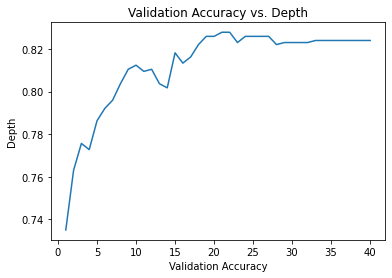

In [999]:
np.random.seed(42)
max_acc, max_depth = test_vacc(1, 40)
print("Best Depth:", max_depth)
print("Best Accuracy:", max_acc)

We see in the plot that the as the decision tree depth increases, the validation accuracy increases (slightly stochastically), due to better splitting of the dataset. However, beyond a certain depth, we see it level off and actually drop. This is because of overfitting. As the depth increases, overfitting of the tree causes the tree to be heavily dependent on outliers in the training data, which causes the validation accuracy to go down.

### Q3.6

Titanic visualization:

In [1538]:
importlib.reload(decision_tree_starter)

<module 'decision_tree_starter' from '/Users/shri/Documents/Documents - Shrihan’s MacBook Air/CS189/hw5_release/hw5_code/decision_tree_starter.py'>

In [1539]:
tset = io.loadmat("datasets/titanic/prep_titanic.mat")

In [1524]:
import decision_tree_starter as dt
import importlib
from tqdm import tqdm
np.random.seed(42)

In [1525]:
Xt = tset["training_data"]
yt = tset["training_labels"]

In [1545]:
ttree = dt.DecisionTree(max_depth = 5)

In [1546]:
tdtree = ttree.fit(Xt, yt[0])

This is a printout of the decision tree and splits produced (Titanic):

In [1547]:
print(tdtree.strtitanic())

'sex=female > 0.05'
	'age > 12.354194999999999'
		'sibsp > 1.0'
			'fare > 15.89999'
				'age > 0.74999'
					'Leaf Label: 1'
					'Leaf Label: 0'
				'Leaf Label: 1'
			'Leaf Label: 0'
		'pclass > 1.1'
			'age > 54.8'
				'cabin=C52 > 0.05'
					'Leaf Label: 0'
					'Leaf Label: 1'
				'age > 79.99999'
					'Leaf Label: 0'
					'Leaf Label: 1'
			'ticket=1601 > 0.05'
				'fare > 29.4'
					'Leaf Label: 0'
					'Leaf Label: 0'
				'age > 27.99999'
					'Leaf Label: 1'
					'Leaf Label: 1'
	'pclass > 2.0'
		'cabin=C22 C26 > 0.05'
			'cabin=C55 C57 > 0.05'
				'pclass > 1.05'
					'Leaf Label: 1'
					'Leaf Label: 1'
				'Leaf Label: 0'
			'Leaf Label: 0'
		'fare > 22.599999999999998'
			'age > 16.558355'
				'fare > 21.07499'
					'Leaf Label: 1'
					'Leaf Label: 0'
				'fare > 7.720415'
					'Leaf Label: 1'
					'Leaf Label: 0'
			'ticket=347077 > 0.99999'
				'Leaf Label: 0'
				'Leaf Label: 1'

